November: The final notebook used to create a domain, create a coordinate grid, extract the realistic bathymetry, and create the corresponding idealized bathymetry.

In [3]:
import scipy as sc, scipy.io
import numpy as np
import matplotlib.cm as cm
import cmocean as cmo
import matplotlib.pyplot as plt
%matplotlib inline

import sys
sys.path.append('/ocean/imachuca/Canyons/mackenzie_canyon/tools/')
import functions_idealized
import functions_grid
import functions_realistic
import functions_plot

import netCDF4 as nc
from netCDF4 import Dataset

# Variables

In [4]:
#doubling resolution Jan 26
#quadrupling resolution Jun 28
x_final =  273 #483#120 * 4
y_final =  int(0.65 * x_final)#363#int(0.75 * x_final)

extension_m = 190*1000#108061

smooth_factor = 0.2
max_norm_depth_diff = 0.70834736504

#search_x = [-1000000, -1450000, -1750000, -1400000]
search_x = [-900000, -1450000, -1750000, -1400000]

In [5]:
x_final, y_final

(273, 177)

# Set up

In [6]:
x_region, y_region, z_region = functions_plot.def_regionS()
cmap, norm = functions_plot.Colormap()

In [7]:
x_wall, y_wall, fluid_depth = functions_idealized.base_measurements()

# 2. Base Region

In [8]:
lon_s_corners_can, lat_s_corners_can = functions_grid.match_domain(x_wall, y_wall, search_x)

print(lon_s_corners_can.shape)

(4, 1)


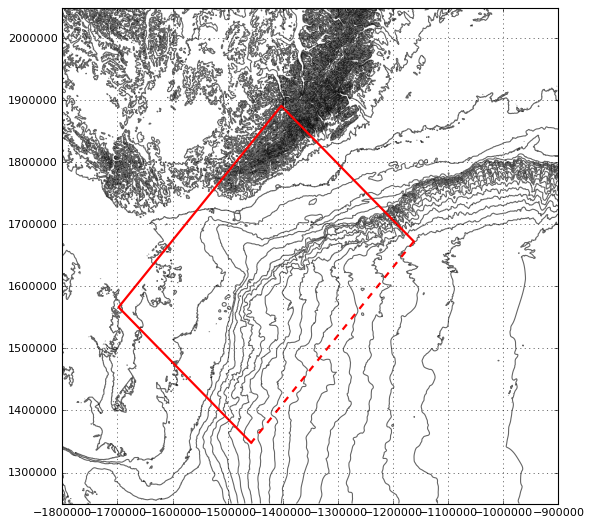

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8)); ax.grid()
fig, ax = functions_plot.plot_region(fig, ax, x_region, y_region, z_region)
ax.plot(lon_s_corners_can, lat_s_corners_can, 'r', linewidth=2)
ax.plot(lon_s_corners_can[::3], lat_s_corners_can[::3], 'r', linewidth=2, linestyle='--')

# 3. Extended Region

In [10]:
x_wall_ext = x_wall + extension_m

In [11]:
lon_s_corners, lat_s_corners = functions_grid.match_domain(x_wall_ext, y_wall, search_x)

print(lon_s_corners.shape)

(4, 1)


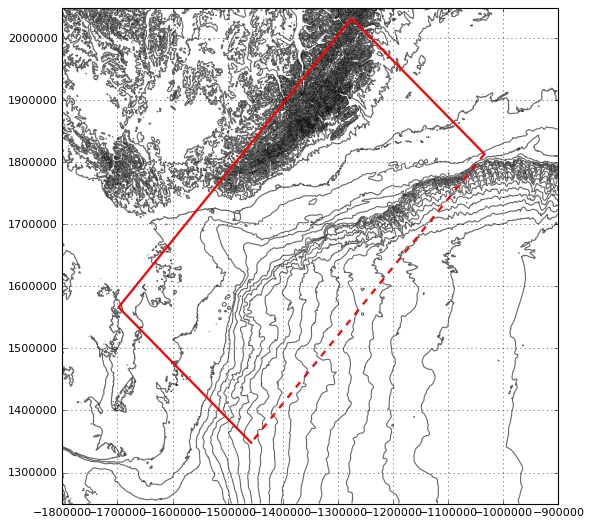

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8)); ax.grid()
fig, ax = functions_plot.plot_region(fig, ax, x_region, y_region, z_region)
ax.plot(lon_s_corners, lat_s_corners, 'r', linewidth=2)
ax.plot(lon_s_corners[::3], lat_s_corners[::3], 'r', linewidth=2, linestyle='--')

# 4. Extended Coordinates

In [13]:
lon_g_corners, lat_g_corners = functions_grid.transform_coords(lon_s_corners, lat_s_corners, 'SG')

lonW, latW, lonE, latE = functions_grid.get_southern_points(lon_g_corners, lat_g_corners)

lon_g_grid, lat_g_grid = functions_grid.create_grid(x_final, y_final, lonW, latW, lonE, latE)

lon_s_grid, lat_s_grid = functions_grid.transform_coords(lon_g_grid, lat_g_grid, 'GS')

print(lon_g_grid.shape, lon_s_grid.shape)

dx (distance between the corner southern point and its neighbour) [km]: 2.26316954771
dx2 (distance between the corner northern point and its neighbour) [km]: 2.25874191436
(273, 177) (273, 177)


In [14]:
print('width of domain: ', str((lon_g_grid.shape[0]-3)*2.26316954771))
print('width of domain: ', str((lon_g_grid.shape[0]-3)*2.25874191436))

width of domain:  611.0557778817
width of domain:  609.8603168771999


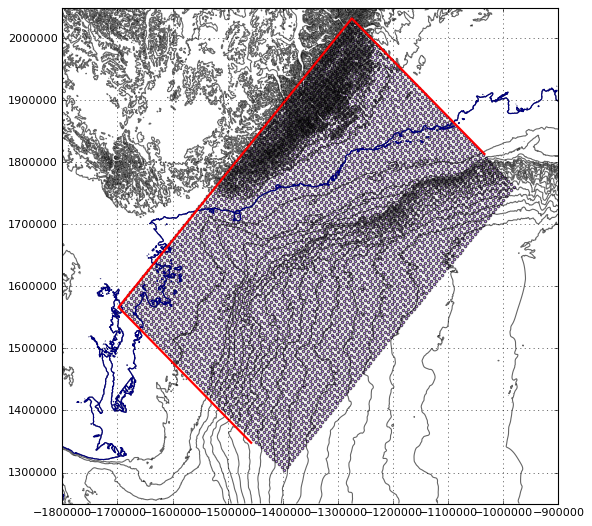

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8)); ax.grid()
fig, ax = functions_plot.plot_region(fig, ax, x_region, y_region, z_region)
ax.contour(x_region, y_region, z_region, levels=[0])
ax.scatter(lon_s_grid[::3,::3], lat_s_grid[::3,::3], c='BlueViolet', s=5, alpha=0.6)
ax.plot(lon_s_corners, lat_s_corners, 'r', linewidth=2)

# 5. Extended (Real) Bathymetry

In [20]:
import imp
imp.reload(functions_realistic)

<module 'functions_realistic' from '/ocean/imachuca/Canyons/mackenzie_canyon/tools/functions_realistic.py'>

In [16]:
dx = functions_grid.find_dx(lon_g_grid, lat_g_grid)
#index = int(extension_m / (dx * 1000))
index = int((lon_g_grid.shape[0]-3)*0.25)
print(index)

67


In [16]:
z_positive = functions_realistic.canyon_for_model(fluid_depth, index, lon_s_grid, lat_s_grid, x_region, y_region, z_region)

z_positive.shape

(174, 270)

In [21]:
z_original, z_smoothed = functions_realistic.smooth_canyon(max_norm_depth_diff, smooth_factor, z_positive)

z_smoothed.shape

(174, 270)

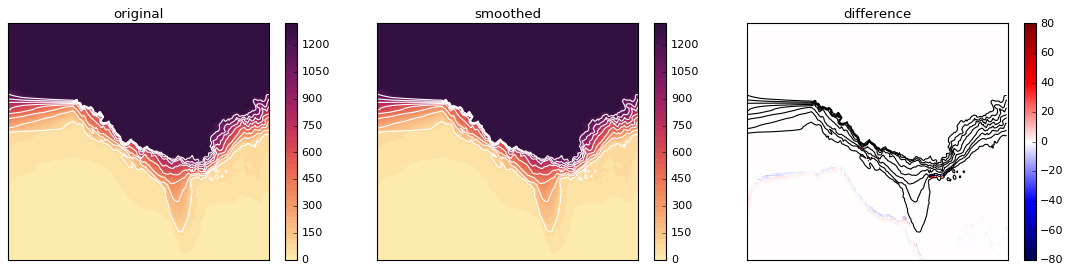

In [22]:
fig, axes = plt.subplots(1,3,figsize=(14,3.5)); plt.tight_layout()
difference = np.subtract(z_smoothed, z_original)
c0 = axes[0].contourf(z_original, 50, cmap = cmo.cm.matter)
c1 = axes[1].contourf(z_smoothed, 50, cmap = cmo.cm.matter)
c2 = axes[2].pcolormesh(difference, cmap = cm.seismic, vmin=-80, vmax=80)
axes[0].contour(z_original, levels = np.arange(80, 1200, 150), linestyles='solid', colors = 'w')
axes[1].contour(z_smoothed, levels = np.arange(80, 1200, 150), linestyles='solid', colors = 'w')
axes[2].contour(z_original, levels = np.arange(80, 1200, 150), colors='k',linestyles='-')
for cs, i, ttl in zip([c0, c1, c2], np.arange(3), ['original', 'smoothed', 'difference']):
    fig.colorbar(cs, ax = axes[i]); axes[i].set_title(ttl)
    axes[i].xaxis.set_visible(False); axes[i].yaxis.set_visible(False)

#axes[0].contourf(z_positive, 50, cmap = cmo.cm.matter)
#axes[0].contour(z_positive, levels = np.arange(80, 1200, 150), linestyles='solid', colors = 'w')

# 7. Idealized Canyon

In [17]:
x_wall, y_wall = functions_idealized.extended_measurements(lon_s_grid, lat_s_grid)

x_wall, y_wall, w_break, w_mid, w_head, cR, L, p,\
y_coast, y_head, y_break, y_pointA, y_pointB, y_paral, y_base, fluid_depth,\
z_bottom, z_paral, z_pointA, z_pointB, z_break, z_coast = functions_idealized.Mackenzie_measurements(x_wall, y_wall)

In [18]:
xsize, ysize = x_final-2, y_final-2

x, y, y_edge, X, Y = functions_idealized.set_domain_grid(xsize, ysize, x_wall, y_wall)

z_ideal = functions_idealized.make_topo_smooth(y_edge, y_base, y_paral, y_pointA, y_pointB, y_break, y_head, y_coast,
                                               cR, L, p, x, x_wall, w_break, w_mid, w_head,
                                               fluid_depth, z_bottom, z_paral, z_pointA, z_pointB, z_break, z_coast)

In [19]:
z_nocanyon = functions_idealized.make_no_canyon(y_edge, y_base, y_break, y_coast, x, x_wall,
                                                 fluid_depth, z_bottom, z_break, z_coast)

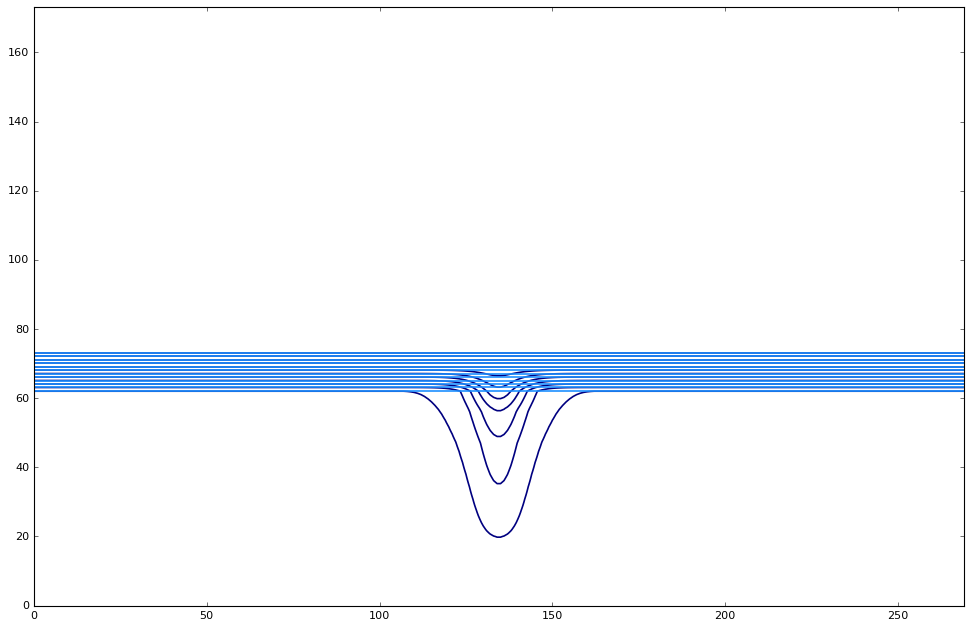

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(15,10))
ax.set_aspect(aspect='equal')
levels = np.arange(80, 1200, 100)
c1 = ax.contour(z_ideal, levels=levels, colors='Navy', linewidths=1.5, label='ideal')
c2 = ax.contour(z_nocanyon, levels=levels, colors='dodgerblue', linewidths=1.5, label='ideal no canyon')
#c3 = ax.contour(z_smoothed, levels=levels, colors='gray', linewidths=1.5, label='real')
#c4 = ax.contour(z_nocanyon_real, levels = [0, 40, 80, 200, 400, 800, 1299], colors='k', linewidths=1.5)
#z_ideal.shape, z_nocanyon.shape, z_smoothed.shape

# 8. Make files

1. Coordinates Grid 
2. Idealized canyon bathymetry

In [27]:
filename = 'grid_for_agrif.nc'
title = 'Mackenzie Coordinate Grid 05'
description = '270x174 (For Agrif). Extended for Kelvin wave. April 2018.'
ipynbname = 'final_bathymetry.ipynb'
functions_grid.create_grid_file(x_final, y_final, lon_g_grid, lat_g_grid, filename, title, description, ipynbname)

In [28]:
filename = 'ideal_bathy_for_agrif.nc'
title = 'Idealized Bathymetry Version 08'
description = '270x174 (For Agrif). Extended for Kelvin wave. April 2018.'
ipynbname = 'final_bathymetry.ipynb'
functions_idealized.create_bathy_file(X, Y, z_ideal, filename, title, description, ipynbname)

In [29]:
filename = 'real_bathy_for_agrif.nc'
title = 'Realistic Bathymetry Version 05'
description = '270x174 (For Agrif). Extended for Kelvin wave. April 2018.'
ipynbname = 'final_bathymetry.ipynb'
functions_realistic.create_bathy_file(z_smoothed, filename, title, description, ipynbname)

In [23]:
filename = 'ideal_bathy_for_agrif_nocanyon.nc'
title = 'No Canyon - Idealized Bathymetry Version 08'
description = '270x174 (For Agrif). Extended for Kelvin wave. April 2018.'
ipynbname = 'final_bathymetry.ipynb'
functions_idealized.create_bathy_file(X, Y, z_nocanyon, filename, title, description, ipynbname)

** Values for refine_mackenzie.ipynb:**

41 min for real smooth

In [34]:
xsize, ysize

(271, 175)

In [31]:
! ls /ocean/imachuca/Canyons/mackenzie_canyon/bathymetry/NEMO_files/idealized/

ideal_bathy_01.nc  ideal_bathy_04.nc	     ideal_bathy_for_agrif_nocanyon.nc
ideal_bathy_02.nc  ideal_bathy_05.nc	     ideal_bathy_for_agrif_orig.nc
ideal_bathy_03.nc  ideal_bathy_for_agrif.nc  ideal_bathy_quad.nc


In [32]:
! ls /ocean/imachuca/Canyons/mackenzie_canyon/bathymetry/NEMO_files/realistic/

real_bathy_01.nc	 real_bathy_for_agrif_nocanyon.nc
real_bathy_02.nc	 real_bathy_for_agrif_orig.nc
real_bathy_for_agrif.nc


In [33]:
! ls /ocean/imachuca/Canyons/mackenzie_canyon/coordinates/raw_coordinates/

grid_01.nc  grid_02.nc	grid_for_agrif.nc  grid_for_agrif_orig.nc  grid_quad.nc
